#### Figure 4b. Visualization of the 2D latent space

/tmp/ipykernel_2548062/2694496030.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] * len(np.arange(-6, 8, 2)))
/tmp/ipykernel_2548062/2694496030.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] * len(np.arange(-6, 8, 2)))


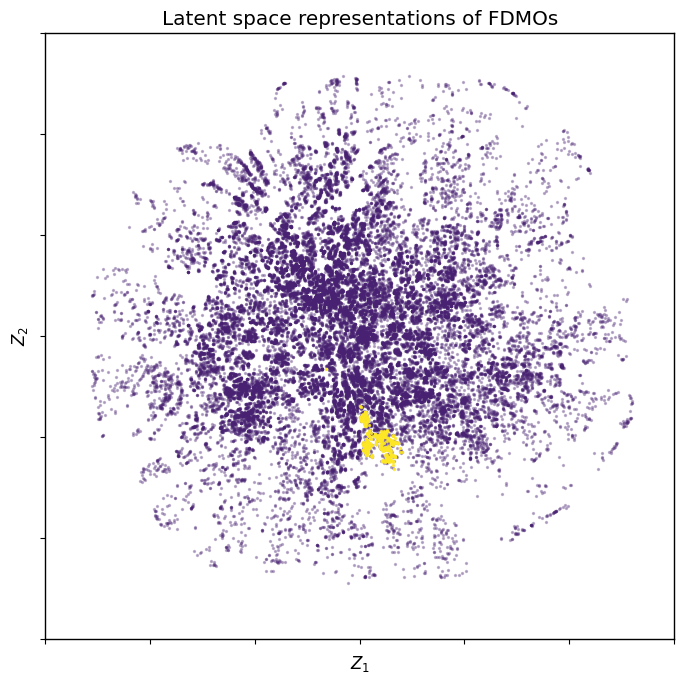

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re

# Read latent space representation
with open("../model/PF01494/NoCV_latent_space_d2_layer4_w0.0005_b256_l0.0005_beta1_1000epoch_seed19.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
t_key = data['t_key']
t_mu = data['t_mu']

# Define colors 
purple_color = (0.281, 0.129, 0.449, 1.0)
yellow_color = plt.cm.viridis(1.0)

# Find indices of sequences in t_key matching 'AncXXX_v2' or 'AncXXXa_v2'
pattern = re.compile(r'Anc\d+(?:a)?_v2')
match_indices = [i for i, k in enumerate(t_key) if pattern.fullmatch(k)]
t_mu_match = t_mu[match_indices]

# Plot the latent space
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'regular'

fig, ax = plt.subplots(figsize=(7, 7))

# Plot sequences in 'key' colored in purple
ax.scatter(mu[:, 0], mu[:, 1], c=[purple_color], alpha=0.3, s=2, label='Sequences in key')

# Plot matched sequences in 't_key' colored in yellow
ax.scatter(t_mu_match[:, 0], t_mu_match[:, 1], c=[yellow_color], alpha=0.8, s=2, label='AncXXX_v2 sequences')

# Customize plot appearance
ax.set_title('Latent space representations of FDMOs')
ax.set_xlabel("$Z_1$", fontsize=12)
ax.set_ylabel("$Z_2$", fontsize=12)
ax.set_xlim((-6, 6))
ax.set_ylim((-6, 6))
# ax.legend()
# Adjust the border line width
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)  # Set the desired width (e.g., 2)
ax.set_xticklabels([''] * len(np.arange(-6, 8, 2)))
ax.set_yticklabels([''] * len(np.arange(-6, 8, 2)))
fig.tight_layout()

# Save the figure
fig.savefig('../output/PF01494_latent_space_w_anc.png', dpi=300, format='png')
plt.show()


#### Figure 4d. Adjusted mutual information (AMI) between the latent space-based and tree-based clustering

Linkage method: ward
n_clusters = 1, Adjusted Mutual Information (AMI) score: 0.00
n_clusters = 2, Adjusted Mutual Information (AMI) score: 0.37
n_clusters = 3, Adjusted Mutual Information (AMI) score: 0.61
n_clusters = 4, Adjusted Mutual Information (AMI) score: 0.72
n_clusters = 5, Adjusted Mutual Information (AMI) score: 0.71
n_clusters = 6, Adjusted Mutual Information (AMI) score: 0.75
n_clusters = 7, Adjusted Mutual Information (AMI) score: 0.79
n_clusters = 8, Adjusted Mutual Information (AMI) score: 0.77
n_clusters = 9, Adjusted Mutual Information (AMI) score: 0.74
n_clusters = 10, Adjusted Mutual Information (AMI) score: 0.76
n_clusters = 11, Adjusted Mutual Information (AMI) score: 0.75
Linkage method: average
n_clusters = 1, Adjusted Mutual Information (AMI) score: 0.00
n_clusters = 2, Adjusted Mutual Information (AMI) score: 0.37
n_clusters = 3, Adjusted Mutual Information (AMI) score: 0.60
n_clusters = 4, Adjusted Mutual Information (AMI) score: 0.72
n_clusters = 5, Adjuste

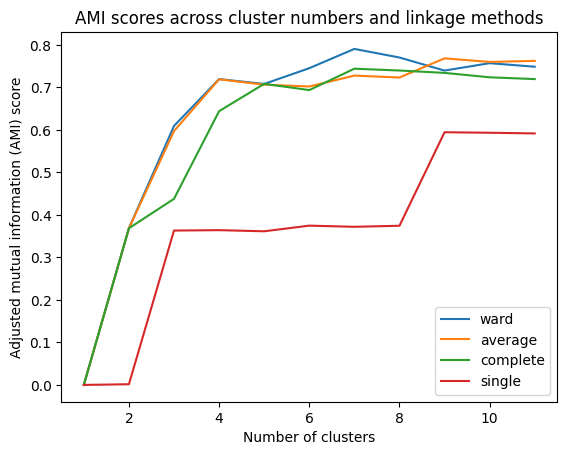

In [6]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ete3 import Tree
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score

# Read the phylogenetic tree of FDMO (with distance)
t1 = Tree("../data/Tree/tree-to-reconstruct.newick", format=0)
num_leaf = len(t1)

# Read the cladogram of FDMO (no distance)
t2 = Tree("../data/Tree/tree-with-ancestors.tree", format=1)

# Label nodes in t1 by t2
for node1, node2 in zip(t1.traverse('preorder'), t2.traverse('preorder')):
    node1.name = node2.name if node2.is_root() or not node2.is_leaf() else node1.name
t1.write(format=1, outfile="../data/Tree/PF01494_label.newick")

# Calculate distances from the root and record all ancestors of each node, including leaf
for node in t1.traverse('preorder'):
    if node.is_root():
        node.add_feature('anc', [])
        node.add_feature('sumdist', 0)
    else:
        node.add_feature('anc', node.up.anc + [node.up.name])
        node.add_feature('sumdist', node.up.sumdist + node.dist)

# Define head nodes manually for 11 distinct clusters in the tree
head_node_names = ['286', '312', '366', '392', '402', '413', '456', '469', '524', '538', '544']

# Get all descendants of each head node
def get_leaves(head_node_names):
    cluster_node_names = {}
    for name in head_node_names:
        cluster_node_names['Anc' + name] = []
        for node in (t1 & name).traverse('preorder'):
            if not node.is_leaf():
                cluster_node_names['Anc' + name].extend(['Anc' + str(node.name) + '_v2', 'Anc' + str(node.name) + 'a' + '_v2'])
    return cluster_node_names

cluster_node_names = get_leaves(head_node_names)

# Cluster labels and dictionary mapping
cluster_list, cluster_label, cluster_dict = [], [], {}
label = 0
for k, nodes in cluster_node_names.items():
    for i in nodes:
        cluster_list.append(str(i))
        cluster_label.append(label)
        cluster_dict[i] = label
    label += 1

# Read latent space data
with open("../model/PF01494/NoCV_latent_space_d2_layer4_w0.0005_b256_l0.0005_beta1_1000epoch_seed19.pkl", 'rb') as file_handle:
    latent_space = pickle.load(file_handle)
key, mu = latent_space['t_key'], latent_space['t_mu']

# Filter mu by relevant keys
key2muindex, key2label = [], []
for m, k in enumerate(key):
    if k in cluster_list:
        key2muindex.append(m)
        key2label.append(cluster_dict[k])
mu_list = mu[key2muindex]
size_count = len(set(key2label))

# Dictionary to store AMI scores for each linkage type
ami_results = {}

# Perform clustering for different numbers of clusters (from 1 to size_count)
linkage_types = ['ward', 'average', 'complete', 'single']
for linkage in linkage_types:
    print(f"Linkage method: {linkage}")
    ami_scores = []
    for n_clusters in range(1, size_count + 1):
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit(mu_list)
        ami_score = adjusted_mutual_info_score(key2label, clustering.labels_)
        ami_scores.append(ami_score)
        print(f"n_clusters = {n_clusters}, Adjusted Mutual Information (AMI) score: {ami_score:.2f}")
    ami_results[linkage] = ami_scores
    plt.plot(range(1, size_count + 1), ami_scores, label=f'{linkage}')

plt.xlabel('Number of clusters')
plt.ylabel('Adjusted mutual information (AMI) score')
plt.legend()
plt.title('AMI scores across cluster numbers and linkage methods')
plt.savefig("../output/AMI_scores_hierachical_clustering.png", dpi=300, format='png')
plt.show()

# Convert AMI results to a DataFrame and save to Excel
df_ami = pd.DataFrame(ami_results, index=range(1, size_count + 1))
df_ami.index.name = 'Number of Clusters'
df_ami.to_excel('../output/AMI_scores_latentspaceclustering_w_tree.xlsx', sheet_name='AMI Scores')

#### Figure 4d. Color the latent space representations of ancestors based on tree and latent space-based clusterings

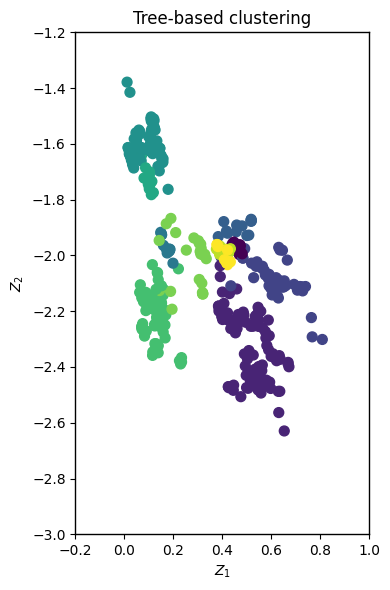

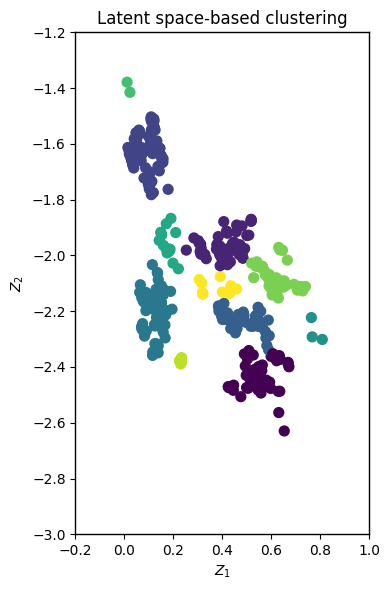

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ete3 import Tree
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score

# Read the phylogenetic tree of FDMO (with distance)
t1 = Tree("../data/Tree/tree-to-reconstruct.newick", format=0)
num_leaf = len(t1)

# Read the cladogram of FDMO (no distance)
t2 = Tree("../data/Tree/tree-with-ancestors.tree", format=1)

# Label nodes in t1 by t2
for node1, node2 in zip(t1.traverse('preorder'), t2.traverse('preorder')):
    node1.name = node2.name if node2.is_root() or not node2.is_leaf() else node1.name
t1.write(format=1, outfile="../data/Tree/PF01494_label.newick")

# Calculate distances from the root and record all ancestors of each node, including leaf
for node in t1.traverse('preorder'):
    if node.is_root():
        node.add_feature('anc', [])
        node.add_feature('sumdist', 0)
    else:
        node.add_feature('anc', node.up.anc + [node.up.name])
        node.add_feature('sumdist', node.up.sumdist + node.dist)

# Define head nodes manually for 11 distinct clusters in the tree
head_node_names = ['286', '312', '366', '392', '402', '413', '456', '469', '524', '538', '544']

# Get all descendants of each head node
def get_leaves(head_node_names):
    cluster_node_names = {}
    for name in head_node_names:
        cluster_node_names['Anc' + name] = []
        for node in (t1 & name).traverse('preorder'):
            if not node.is_leaf():
                cluster_node_names['Anc' + name].extend(['Anc' + str(node.name) + '_v2', 'Anc' + str(node.name) + 'a' + '_v2'])
    return cluster_node_names

cluster_node_names = get_leaves(head_node_names)

# Cluster labels and dictionary mapping for tree-based clusters
cluster_list, cluster_label, cluster_dict = [], [], {}
label = 0
for k, nodes in cluster_node_names.items():
    for i in nodes:
        cluster_list.append(str(i))
        cluster_label.append(label)
        cluster_dict[i] = label
    label += 1

# Read latent space data
with open("../model/PF01494/NoCV_latent_space_d2_layer4_w0.0005_b256_l0.0005_beta1_1000epoch_seed19.pkl", 'rb') as file_handle:
    latent_space = pickle.load(file_handle)
key, mu = latent_space['t_key'], latent_space['t_mu']

# Filter mu by relevant keys and get labels from tree clustering
key2muindex, key2label = [], []
for m, k in enumerate(key):
    if k in cluster_list:
        key2muindex.append(m)
        key2label.append(cluster_dict[k])
mu_list = mu[key2muindex]

# Convert filtered latent space representations to a numpy array for plotting
mu_list = np.array(mu_list)
size_count = len(set(key2label))

# Colored by the tree
fig1, ax1 = plt.subplots(figsize=(4, 6))
scatter1 = ax1.scatter(mu_list[:, 0], mu_list[:, 1], c=key2label, cmap='viridis', s=50)
# Optional: Add a colorbar
# cbar1 = fig1.colorbar(scatter1, ax=ax1)
# cbar1.set_label("Tree Clustering Labels")
ax1.set_title("Tree-based clustering")
ax1.set_xlim(-0.2, 1)  # Set x-axis limits
ax1.set_ylim(-3, -1.2)  # Set y-axis limits
ax1.set_xlabel(r'$Z_1$')
ax1.set_ylabel(r'$Z_2$')
# Hide the tick labels if desired
ax1.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)
# Adjust the border line width
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1)  # Set the desired width
plt.tight_layout()
fig1.savefig("../output/ancestors_tree_clustering.png", dpi=300, format='png')
plt.show()

# Colored by latent space clustering
# Perform clustering in the latent space
latent_space_clustering = AgglomerativeClustering(n_clusters=len(head_node_names), linkage='average').fit(mu_list)
latent_space_labels = latent_space_clustering.labels_

fig2, ax2 = plt.subplots(figsize=(4, 6))
scatter2 = ax2.scatter(mu_list[:, 0], mu_list[:, 1], c=latent_space_labels, cmap='viridis', s=50)
# Optional: Add a colorbar
# cbar2 = fig2.colorbar(scatter2, ax=ax2)
# cbar2.set_label("Latent Space Clustering Labels")
ax2.set_title("Latent space-based clustering")
ax2.set_xlim(-0.2, 1)  # Set x-axis limits
ax2.set_ylim(-3, -1.2)  # Set y-axis limits
ax2.set_xlabel(r'$Z_1$')
ax2.set_ylabel(r'$Z_2$')
# Hide the tick labels if desired
ax2.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)
# Adjust the border line width
for axis in ['top', 'bottom', 'left', 'right']:
    ax2.spines[axis].set_linewidth(1)  # Set the desired width
plt.tight_layout()

fig2.savefig("../output/ancestors_latentspace_clustering.png", dpi=300, format='png')
plt.show()


#### Figure 4d. Correlation between the evolutionary distances and Euclidean distances in the latent space

Pearson correlation between evolutionary and latent space distances: 0.78, p-value: 2.49e-12


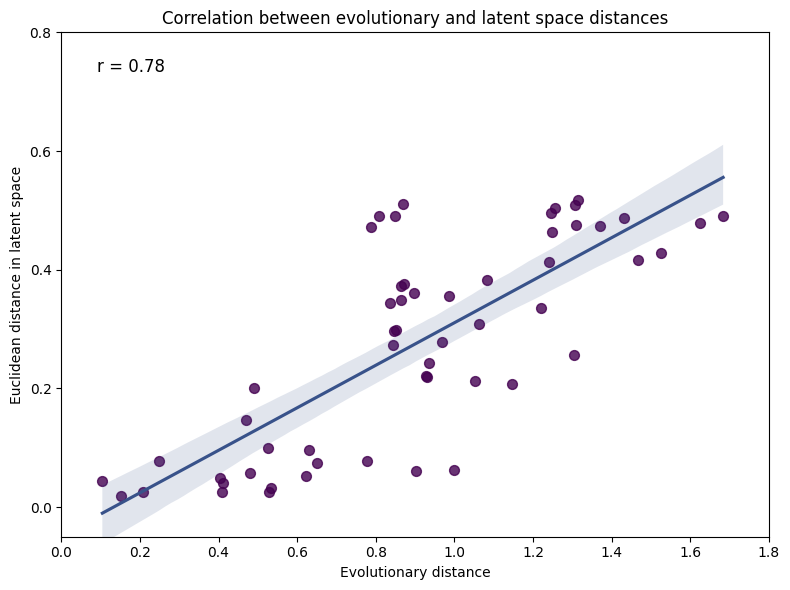

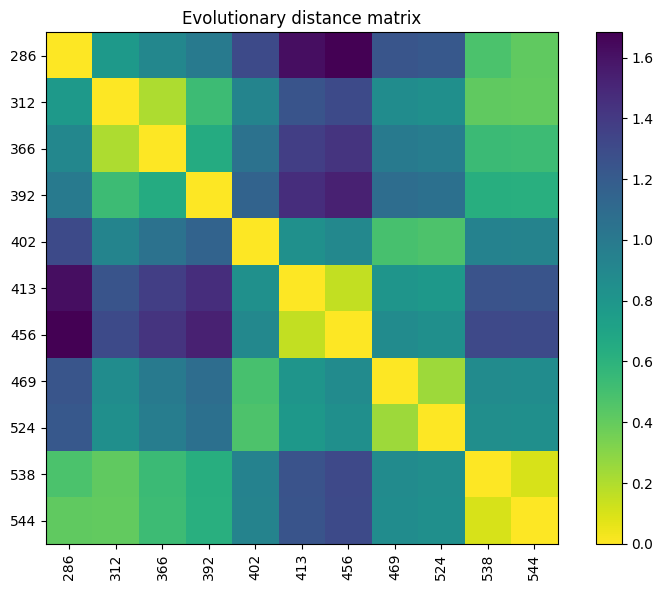

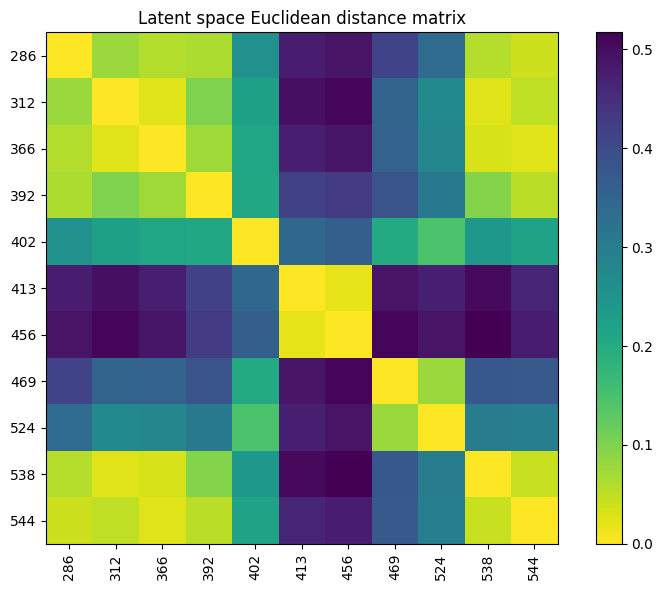

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Import pandas
import seaborn as sns
from ete3 import Tree
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from itertools import combinations  # Import combinations for node pairs

# Read the phylogenetic tree of FDMO (with distance)
t1 = Tree("../data/Tree/tree-to-reconstruct.newick", format=0)
num_leaf = len(t1)

# Read the cladogram of FDMO (no distance)
t2 = Tree("../data/Tree/tree-with-ancestors.tree", format=1)

# Label nodes in t1 by t2
for node1, node2 in zip(t1.traverse('preorder'), t2.traverse('preorder')):
    node1.name = node2.name if node2.is_root() or not node2.is_leaf() else node1.name
t1.write(format=1, outfile="../data/Tree/PF01494_label.newick")

# Calculate distances from the root and record all ancestors of each node, including leaf
for node in t1.traverse('preorder'):
    if node.is_root():
        node.add_feature('anc', [])
        node.add_feature('sumdist', 0)
    else:
        node.add_feature('anc', node.up.anc + [node.up.name])
        node.add_feature('sumdist', node.up.sumdist + node.dist)

# Define head nodes manually
head_node_names = ['286', '312', '366', '392', '402', '413', '456', '469', '524', '538', '544']

# Read latent space data
with open("../model/PF01494/NoCV_latent_space_d2_layer4_w0.0005_b256_l0.0005_beta1_1000epoch_seed19.pkl", 'rb') as file_handle:
    latent_space = pickle.load(file_handle)
key, mu = latent_space['t_key'], latent_space['t_mu']

# Ensure each head node has the correct latent space embedding
head_node_mu = []
available_head_nodes = []
for node in head_node_names:
    formatted_name = 'Anc' + node + '_v2'
    if formatted_name in key:
        head_node_mu.append(mu[key.index(formatted_name)])
        available_head_nodes.append(node)  # Keep track of nodes that are available
    else:
        print(f"Warning: Node {formatted_name} not found in latent space keys.")

# Convert head_node_mu to a NumPy array
head_node_mu = np.array(head_node_mu)

# Check if the number of available head nodes matches
if len(available_head_nodes) < len(head_node_names):
    print("Note: Some head nodes were not found in the latent space data.")

# Generate all unique pairs of available head nodes
node_pairs = list(combinations(available_head_nodes, 2))

# Initialize lists to store node pairs and distances
node_pair_list = []
evolutionary_distance_list = []
latent_space_distance_list = []

# Create a mapping from node names to their indices in head_node_mu
node_to_index = {node: idx for idx, node in enumerate(available_head_nodes)}

# Calculate distances for each pair
for node1, node2 in node_pairs:
    # Get evolutionary distance from the tree
    evo_dist = t1.get_distance(node1, node2)
    evolutionary_distance_list.append(evo_dist)
    
    # Get indices for the latent space embeddings
    idx1 = node_to_index[node1]
    idx2 = node_to_index[node2]
    # Calculate Euclidean distance in latent space
    ls_dist = np.linalg.norm(head_node_mu[idx1] - head_node_mu[idx2])
    latent_space_distance_list.append(ls_dist)
    
    # Append node pair to the list
    node_pair_list.append(f"{node1} - {node2}")

# Create a DataFrame with the results
distances_df = pd.DataFrame({
    'Node ID-to-node ID': node_pair_list,
    'Evolutionary distance': evolutionary_distance_list,
    'Euclidean distance in latent space': latent_space_distance_list
})

# Calculate Pearson correlation
correlation, p_value = pearsonr(evolutionary_distance_list, latent_space_distance_list)
print(f"Pearson correlation between evolutionary and latent space distances: {correlation:.2f}, p-value: {p_value:.2e}")

# Output the DataFrame to an Excel file
distances_df.to_excel('../output/pairwise_distances.xlsx', index=False, engine='openpyxl')

# Continue with your plotting code...
# Plot 1: Correlation plot
fig1 = plt.figure(figsize=(8, 6))
sns.regplot(
    x=evolutionary_distance_list,
    y=latent_space_distance_list,
    ci=95,
    scatter_kws={"s": 50, "color": (0.265, 0.004, 0.317)},
    line_kws={"color": (0.219, 0.320, 0.543)}
)
plt.xlabel('Evolutionary distance')
plt.ylabel('Euclidean distance in latent space')
plt.title(f'Correlation between evolutionary and latent space distances')
plt.text(0.05, 0.95, f'r = {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlim(0, 1.8)  # Set x-axis limits
plt.ylim(-0.05, 0.7)  # Set y-axis limits
# Set ticks
plt.xticks(np.arange(0, 2.0, 0.2))
plt.yticks(np.arange(0, 1.0, 0.2))
plt.tight_layout()
fig1.savefig("../output/tree_latentspace_distance_correlation.png", dpi=300, format='png')
plt.show()

# Optional: Plotting the evolutionary distance matrix
fig2 = plt.figure(figsize=(8, 6))
plt.imshow(squareform(evolutionary_distance_list), cmap='viridis_r')
plt.colorbar()
plt.title("Evolutionary distance matrix")
plt.xticks(ticks=np.arange(len(available_head_nodes)), labels=available_head_nodes, rotation=90)
plt.yticks(ticks=np.arange(len(available_head_nodes)), labels=available_head_nodes)
plt.tight_layout()
fig2.savefig("../output/tree_distances.png", dpi=300, format='png')
plt.show()

# Optional: Plotting the latent space Euclidean distance matrix
fig3 = plt.figure(figsize=(8, 6))
plt.imshow(squareform(latent_space_distance_list), cmap='viridis_r')
plt.colorbar()
plt.title("Latent space Euclidean distance matrix")
plt.xticks(ticks=np.arange(len(available_head_nodes)), labels=available_head_nodes, rotation=90)
plt.yticks(ticks=np.arange(len(available_head_nodes)), labels=available_head_nodes)
plt.tight_layout()
fig3.savefig("../output/latentspace_Euclidean_distances.png", dpi=300, format='png')
plt.show()


#### Figure 4. Focused latent space with highlighted sequences 

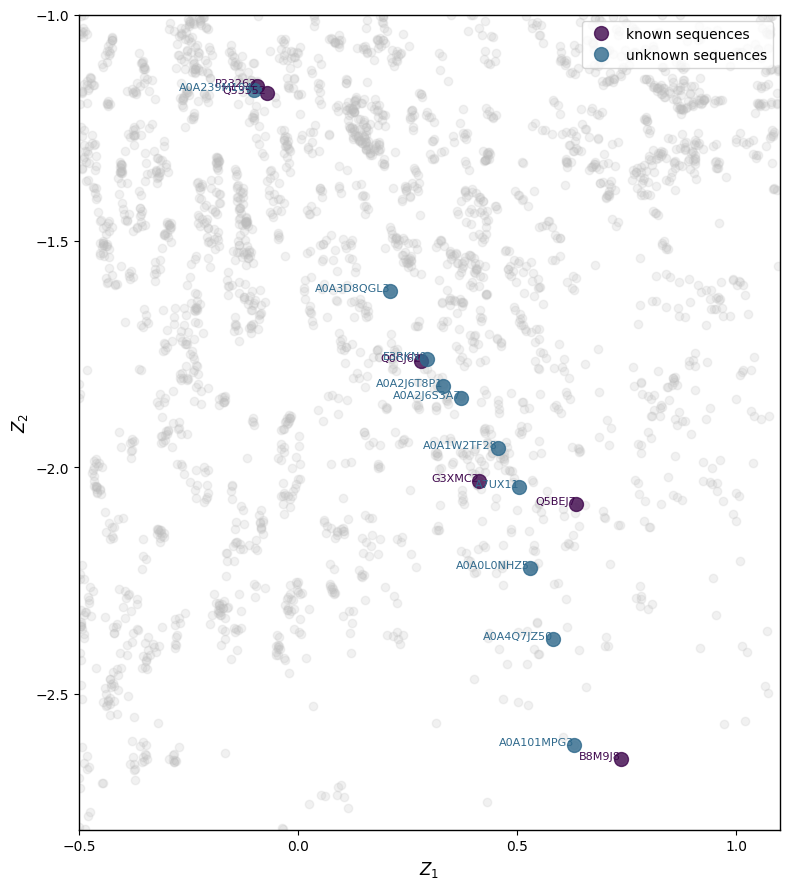

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the latent space representation
with open("../model/PF01494/NoCV_latent_space_d2_layer4_w0.0005_b256_l0.0005_beta1_1000epoch_seed19.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
sigma = data['sigma']
t_key = data['t_key']
t_mu = data['t_mu']
t_sigma = data['t_sigma']

# Combine training and test data
combined_key = key + t_key
combined_mu = np.vstack((mu, t_mu))
combined_sigma = np.vstack((sigma, t_sigma))
key2mu_dict = {k: m for k, m in zip(combined_key, combined_mu)}

# Define sequences to highlight
known = ['B8M9J8', 'Q5BEJ7', 'G3XMC2', 'Q0CJ62', 'P23262', 'Q53552']
unknown = ['A0A101MPG3', 'A0A4Q7JZ50', 'A0A0L0NHZ5', 'A7UX11', 'A0A1W2TF28', 
           'A0A2J6S3A7', 'A0A2J6T8P1', 'A0A3D8QGL3', 'E3RKN0', 'A0A239M104']

# Set up custom colors
custom_gray = (189/255, 189/255, 189/255)
custom_known_color = (63/255, 7/255, 77/255)  # Red for known sequences
custom_unknown_color = (47/255, 105/255, 140/255)  # Green for unknown sequences
custom_frame = (189/255, 189/255, 189/255)

# Define the region to focus on (adjust as needed)
focus_x_range = (-0.5, 1.1)
focus_y_range = (-2.8, -1.0)

def plot_filtered_data(ax, data, keys, keys_to_check, color, label, annotate=False):
    """Filter, plot, and optionally annotate data based on specific keys."""
    indices = [idx for idx, key_val in enumerate(keys) if key_val in keys_to_check]
    filtered_mu = data[indices]
    ax.plot(filtered_mu[:, 0], filtered_mu[:, 1], 'o', color=color, alpha=0.8, markersize=10, label=label)
    
    # Annotate each point if specified
    if annotate:
        for idx in indices:
            ax.text(data[idx, 0], data[idx, 1], keys[idx], fontsize=8, color=color, ha='right')

# Plot with focus on a local region and highlight known and unknown sequences
fig, ax = plt.subplots(figsize=(8, 9))

# Plot training data within the focus range
filtered_mu = mu[(mu[:, 0] >= focus_x_range[0]) & (mu[:, 0] <= focus_x_range[1]) &
                 (mu[:, 1] >= focus_y_range[0]) & (mu[:, 1] <= focus_y_range[1])]
ax.plot(filtered_mu[:, 0], filtered_mu[:, 1], 'o', color=custom_gray, alpha=0.2, markersize=6)

# Plot and annotate known sequences in the focused region
plot_filtered_data(ax, combined_mu, combined_key, known, custom_known_color, 'known sequences', annotate=True)

# Plot and annotate unknown sequences in the focused region
plot_filtered_data(ax, combined_mu, combined_key, unknown, custom_unknown_color, 'unknown sequences', annotate=True)

# Set axis limits to the focused region
ax.set_xlim(focus_x_range)
ax.set_ylim(focus_y_range)

# Axis labels
ax.set_xlabel("$Z_1$", fontsize=12)
ax.set_ylabel("$Z_2$", fontsize=12)

# Set specific tick positions for x and y axes
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.set_yticks([-2.5, -2.0, -1.5, -1.0])

# Adjust the border line width
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)  # Set the desired width (e.g., 2)

# Hide the tick labels if desired
ax.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)

# Legend
ax.legend(loc='upper right')

# Layout adjustment
fig.tight_layout()

# Save the focused figure
fig.savefig('../output/PF01494_latent_space_focused_with_labels.png', dpi=300, format='png')

plt.show()



#### Figure 4. Focused latent space with highlighted sequences  (color code selectivity)

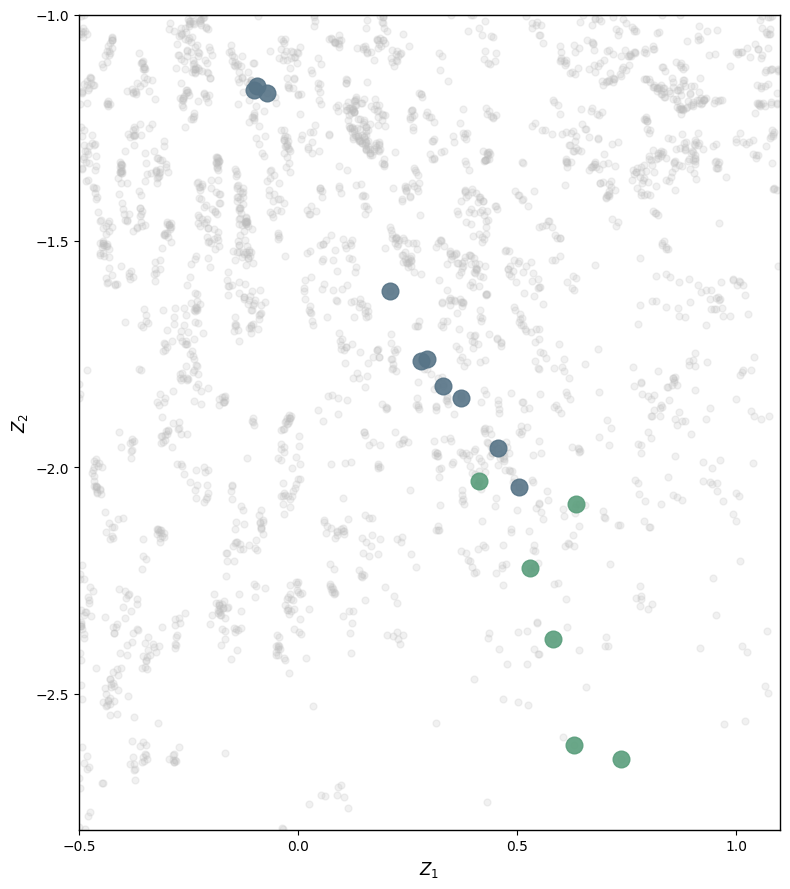

In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the latent space representation
with open("../model/PF01494/NoCV_latent_space_d2_layer4_w0.0005_b256_l0.0005_beta1_1000epoch_seed19.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
sigma = data['sigma']
t_key = data['t_key']
t_mu = data['t_mu']
t_sigma = data['t_sigma']

# Combine training and test data
combined_key = key + t_key
combined_mu = np.vstack((mu, t_mu))
combined_sigma = np.vstack((sigma, t_sigma))
key2mu_dict = {k: m for k, m in zip(combined_key, combined_mu)}

# Define sequences to highlight
known = ['B8M9J8', 'Q5BEJ7', 'G3XMC2', 'Q0CJ62', 'P23262', 'Q53552']
unknown = ['A0A101MPG3', 'A0A4Q7JZ50', 'A0A0L0NHZ5', 'A7UX11', 'A0A1W2TF28', 
           'A0A2J6S3A7', 'A0A2J6T8P1', 'A0A3D8QGL3', 'E3RKN0', 'A0A239M104']
C1 = ['A7UX11', 'A0A1W2TF28', 'A0A2J6S3A7', 'A0A2J6T8P1', 'A0A3D8QGL3', 
      'E3RKN0', 'A0A239M104', 'Q0CJ62', 'P23262', 'Q53552']
C3 = ['B8M9J8', 'Q5BEJ7', 'G3XMC2', 'A0A101MPG3', 'A0A4Q7JZ50', 'A0A0L0NHZ5']

# Set up custom colors
custom_gray = (189/255, 189/255, 189/255)
custom_known_color = (63/255, 7/255, 77/255)  # Red for known sequences
custom_unknown_color = (47/255, 105/255, 140/255)  # Green for unknown sequences
custom_frame = (189/255, 189/255, 189/255)
custom_C1 = (87/255, 116/255, 135/255)
custom_C3 = (90/255, 158/255, 124/255)

# Define the region to focus on (adjust as needed)
focus_x_range = (-0.5, 1.1)
focus_y_range = (-2.8, -1.0)

def plot_filtered_data(ax, data, keys, keys_to_check, color, label, annotate=False):
    """Filter, plot, and optionally annotate data based on specific keys."""
    indices = [idx for idx, key_val in enumerate(keys) if key_val in keys_to_check]
    filtered_mu = data[indices]
    ax.plot(filtered_mu[:, 0], filtered_mu[:, 1], 'o', color=color, alpha=0.9, markersize=12, label=label)
    
    # Annotate each point if specified
    if annotate:
        for idx in indices:
            ax.text(data[idx, 0], data[idx, 1], keys[idx], fontsize=8, color=color, ha='right')

# Plot with focus on a local region and highlight known and unknown sequences
fig, ax = plt.subplots(figsize=(8, 9))

# Plot training data within the focus range
filtered_mu = mu[(mu[:, 0] >= focus_x_range[0]) & (mu[:, 0] <= focus_x_range[1]) &
                 (mu[:, 1] >= focus_y_range[0]) & (mu[:, 1] <= focus_y_range[1])]
ax.plot(filtered_mu[:, 0], filtered_mu[:, 1], 'o', color=custom_gray, alpha=0.2, markersize=5)

# Plot and annotate known sequences in the focused region
plot_filtered_data(ax, combined_mu, combined_key, C1, custom_C1, 'C1-selectivity', annotate=False)

# Plot and annotate unknown sequences in the focused region
plot_filtered_data(ax, combined_mu, combined_key, C3, custom_C3, 'C3-selectivity', annotate=False)

# Set axis limits to the focused region
ax.set_xlim(focus_x_range)
ax.set_ylim(focus_y_range)

# Axis labels
ax.set_xlabel("$Z_1$", fontsize=12)
ax.set_ylabel("$Z_2$", fontsize=12)

# Set specific tick positions for x and y axes
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.set_yticks([-2.5, -2.0, -1.5, -1.0])

# Adjust the border line width
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)  # Set the desired width (e.g., 2)

# Hide the tick labels if desired
ax.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)

# Legend
# ax.legend(loc='upper right')

# Layout adjustment
fig.tight_layout()

# Save the focused figure
# fig.savefig('../output/PF01494_latent_space_focused_with_labels.png', dpi=300, format='png')

plt.show()

#### Reconstruction accuracy of ancestral FDMO sequences

In [17]:
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):

    def __init__(self, num_aa_type, dim_latent_vars, dim_msa_vars, num_hidden_units):
        super(VAE, self).__init__()

        ## num of amino acid types
        self.num_aa_type = num_aa_type

        ## dimension of latent space
        self.dim_latent_vars = dim_latent_vars

        ## dimension of binary representation of sequences
        self.dim_msa_vars = dim_msa_vars

        ## num of hidden neurons in encoder and decoder networks
        self.num_hidden_units = num_hidden_units

        ## encoder
        self.encoder_linears = nn.ModuleList()
        self.encoder_linears.append(nn.Linear(dim_msa_vars, num_hidden_units[0]))
        for i in range(1, len(num_hidden_units)):
            self.encoder_linears.append(nn.Linear(num_hidden_units[i-1], num_hidden_units[i]))
            #self.encoder_linears.append(nn.BatchNorm1d(num_hidden_units[i]))
        self.encoder_mu = nn.Linear(num_hidden_units[-1], dim_latent_vars, bias = True)
        self.encoder_logsigma = nn.Linear(num_hidden_units[-1], dim_latent_vars, bias = True)

        ## decoder
        self.decoder_linears = nn.ModuleList()
        self.decoder_linears.append(nn.Linear(dim_latent_vars, num_hidden_units[-1]))
        for i in range(1, len(num_hidden_units)):
            self.decoder_linears.append(nn.Linear(num_hidden_units[-i], num_hidden_units[-i-1]))
            #self.decoder_linears.append(nn.BatchNorm1d(num_hidden_units[-i-1]))
        self.decoder_linears.append(nn.Linear(num_hidden_units[0], dim_msa_vars))

    def encoder(self, x):
        '''
        encoder transforms x into latent space z
        '''
        
        h = x
        for T in self.encoder_linears:
            h = T(h)
            h = torch.tanh(h)
        mu = self.encoder_mu(h)
        sigma = torch.exp(self.encoder_logsigma(h))
        return mu, sigma

    def decoder(self, z):
        '''
        decoder transforms latent space z into p, which is the log probability  of x being 1.
        '''
        
        h = z
        for i in range(len(self.decoder_linears)-1):
            h = self.decoder_linears[i](h)
            h = torch.tanh(h)
        h = self.decoder_linears[-1](h)

        fixed_shape = tuple(h.shape[0:-1])
        h = torch.unsqueeze(h, -1)
        h = h.view(fixed_shape + (-1, self.num_aa_type))
          
        log_p = F.log_softmax(h, dim = -1)
        log_p = log_p.view(fixed_shape + (-1,))
        
        return log_p

    def compute_weighted_elbo(self, x, weight):
        ## sample z from q(z|x)
        mu, sigma = self.encoder(x)
        eps = torch.randn_like(sigma) 
        '''Returns a tensor with the same size as input that is filled with 
        random numbers from a normal distribution with mean 0 and variance 1.'''
        z = mu + sigma*eps

        ## compute log p(x|z)
        log_p = self.decoder(z)
        log_PxGz = torch.sum(x*log_p, -1)

        ## compute elbo
        elbo = log_PxGz - KLD_beta*torch.sum(0.5*(sigma**2 + mu**2 - 2*torch.log(sigma) - 1), -1)
        weight = weight / torch.sum(weight)
        elbo = torch.sum(elbo*weight)
        
        return elbo

    def compute_elbo_with_multiple_samples(self, x, num_samples):
        with torch.no_grad():
            x = x.expand(num_samples, x.shape[0], x.shape[1])
            mu, sigma = self.encoder(x)
            eps = torch.randn_like(mu)
            z = mu + sigma * eps
            log_Pz = torch.sum(-0.5*z**2 - 0.5*torch.log(2*z.new_tensor(np.pi)), -1)
            log_p = self.decoder(z)
            log_PxGz = torch.sum(x*log_p, -1)
            log_Pxz = log_Pz + log_PxGz

            log_QzGx = torch.sum(-0.5*(eps)**2 -
                                 0.5*torch.log(2*z.new_tensor(np.pi))
                                 - torch.log(sigma), -1)
            log_weight = (log_Pxz - log_QzGx).detach().data
            log_weight = log_weight.double()
            log_weight_max = torch.max(log_weight, 0)[0]
            log_weight = log_weight - log_weight_max
            weight = torch.exp(log_weight)
            elbo = torch.log(torch.mean(weight, 0)) + log_weight_max
            return elbo      

# Define the check_recon_with_keys function
def check_recon_with_keys(validation, keys):
    x = validation.to(DEVICE)
    mu, sigma = vae.encoder(x)
    log_p = vae.decoder(mu)
    x_hat = torch.exp(log_p)
    x = x.cpu().numpy()
    x_hat = x_hat.detach().cpu().numpy()
    x = np.reshape(x, (x.shape[0], len_protein, num_res_type))
    x_hat = np.reshape(x_hat, (x_hat.shape[0], len_protein, num_res_type))
    x = x.argmax(-1)
    x_hat = x_hat.argmax(-1)
    differences = np.abs(x - x_hat)
    differences = np.clip(differences, 0, 1)
    total_differences = np.sum(differences, axis=1)
    reconstruction_accuracy = 1 - total_differences / len_protein
    return reconstruction_accuracy

# Load testing dataset
input_file = '../data/encoding'
with open(f"{input_file}/t_seq_msa_binary.pkl", "rb") as file_handle:
    t_seq_msa_binary = pickle.load(file_handle)
with open(f"{input_file}/t_seq_weight.pkl", "rb") as file_handle:
    t_seq_weight = pickle.load(file_handle)
with open(f"{input_file}/t_keys_list.pkl", "rb") as file_handle:
    t_seq_keys = pickle.load(file_handle)

# Convert testing dataset to tensors
t_seq_msa_binary = t_seq_msa_binary.astype(np.float32)
t_seq_weight = t_seq_weight.astype(np.float32)
t_seq_weight = torch.from_numpy(t_seq_weight)
t_seq_weight = t_seq_weight/torch.sum(t_seq_weight)
t_seq_msa_binary = torch.from_numpy(t_seq_msa_binary)

# Set dataset parameters
num_seq = t_seq_msa_binary.shape[0]
len_protein = 352
num_res_type = 21
t_seq_msa_binary = t_seq_msa_binary.reshape((num_seq, -1))  # Ensure flattened shape

# Load the trained VAE model
dim = 2
layers = [2048, 1024, 128, 32]
DEVICE = torch.device("cpu")
output_path = '../model/PF01494/NoCV_vae_d2_lr4_w0.0005_b256_l0.0005_beta1_1000epoch_seed19.model'
vae = VAE(num_aa_type = 21,
        dim_latent_vars = dim,
        dim_msa_vars = len_protein * num_res_type,
        num_hidden_units = layers)
vae.load_state_dict(torch.load(f"{output_path}"))
vae.to(DEVICE)
vae.eval()

# Calculate mean reconstruction accuracy for "Anc" sequences
anc_recon_list = []
batch_size = 100
for start_idx in range(0, num_seq, batch_size):
    end_idx = min(start_idx + batch_size, num_seq)
    batch_msa = t_seq_msa_binary[start_idx:end_idx]
    batch_keys = t_seq_keys[start_idx:end_idx]

    # Filter sequences with IDs starting with "Anc"
    anc_indices = [i for i, key in enumerate(batch_keys) if key.startswith("Anc")]
    if anc_indices:
        filtered_msa = batch_msa[anc_indices]
        # print(filtered_msa.shape)
        filtered_keys = [batch_keys[i] for i in anc_indices]
        # print(filtered_keys)
        reconstruction_accuracy = check_recon_with_keys(filtered_msa, filtered_keys)
        anc_recon_list.extend(reconstruction_accuracy)

# Compute and print the mean reconstruction accuracy
if anc_recon_list:
    mean_anc_reconstruction_accuracy = np.mean(anc_recon_list) * 100
    print(f"Mean reconstruction accuracy for 'Anc' sequences: {mean_anc_reconstruction_accuracy:.2f}%")
else:
    print("No sequences with IDs starting with 'Anc' were found in the testing dataset.")


Mean reconstruction accuracy for 'Anc' sequences: 64.22%
